# Práctica final Métodos Generativos
Realizada por:
Jorge Carrasco, Iván López e Ismael Perdomo

18 de diciembre de 2023

El presente notebook incluye el entrenamiento completo del modelo descrito en la memoria, sirviendo como complemento a la misma, y está dividido en diferentes secciones para facilitar la navegación

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocesamiento de datos

Módulo en el que se preprocesan los datos para alimentar las diferentes redes de las que consta el proyecto.

## Imports

In [ ]:
import numpy as np
import imutils
import dlib
import cv2
import time

from imutils import face_utils
from google.colab.patches import cv2_imshow

## Función para definir donde se coloca el bigote

Esta función hace uso de las librerías cv2 y dlib para identificar la zona donde se debe colocar el bigote. Para ello, hemos seleccionado manualmente los puntos faciales entre los que centrar el bigote: 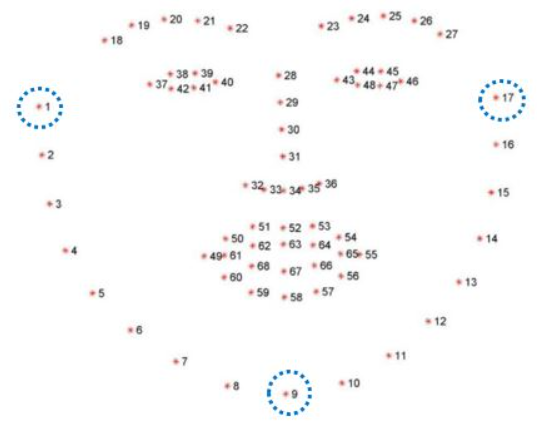.\

In [ ]:
def mask_point_detection(image, detector, predictor):
    # Cambia el tamaño de la imagen a 224x224 píxeles usando interpolación de área
    image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)

    # Convierte la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Utiliza el detector de cara para encontrar caras en la imagen
    rects = detector(gray, 1)

    # Itera sobre las caras detectadas en la imagen
    for (i, rect) in enumerate(rects):
        # Utiliza el predictor para predecir la forma facial en la región de la cara
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # Obtiene las coordenadas del rectángulo que rodea la cara
        (x, y, w, h) = face_utils.rect_to_bb(rect)

        # Dibuja un rectángulo alrededor de la región de interés en la imagen
        cv2.rectangle(image, (shape[48][0]-15, shape[34][1]-20), (shape[54][0]+15, shape[57][1]+5), (255, 0, 0), 1)

        # Define las coordenadas de la región de interés en términos de puntos izquierdo, superior, derecho e inferior
        [x_left, y_left, x_right, y_right] =  shape[48][0]-15, shape[34][1]-20, shape[54][0]+15, shape[57][1]+5
        point = [x_left, y_left, x_right, y_right]  # caja de puntos

        # Dibuja círculos en cada punto facial detectado
        for (x, y) in shape:
            cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
            # cv2_imshow(image)

    # Devuelve las coordenadas de la región de interés (puntos izquierdo, superior, derecho e inferior)
    return point

# example
# image = '/content/drive/MyDrive/maskGAN/data/without_mask/000012.jpg'
# image = cv2.imread(image)
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor('/content/drive/MyDrive/maskGAN/shape_predictor_68_face_landmarks.dat')
# mask_point_detection(image, detector, predictor)

## Función para colocar el bigote

En este función se coloca de manera aleatoria uno de los 6 tipos distintos de bigotes de nuestro dataset sobre las imágenes de las personas sin bigote.

Posteriormente se concatena la imagen de la persona con el bigote artificial, con la imagen original, produciendo duplas que, junto a los mapas de activación de los bigotes (binary_image), servirán como pares de entrenamiento y label.

In [ ]:
def image_processing(image, mask_image, point, maskname):
    # Directorios de almacenamiento para imágenes y imágenes binarias
    save_image_dir = '/content/drive/MyDrive/MG_Utils/data/train/image1'
    save_binary_image_dir = '/content/drive/MyDrive/MG_Utils/data/binary_image1'

    # Coordenadas de la región de interés
    x_left, y_left, x_right, y_right = point[0], point[1], point[2], point[3]

    # Comprobación del nombre de la máscara y aplicando procesamiento correspondiente
        # Redimensiona la imagen y la máscara a tamaños específicos
    if x_right > x_left and y_right > y_left:
      image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_AREA)
      original_image = image.copy()
      mask_image = cv2.resize(mask_image, dsize=(x_right-x_left, y_right-y_left), interpolation=cv2.INTER_AREA)

        # Convierte la máscara a escala de grises
      gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
      ret, mask = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
      mask_inv = cv2.bitwise_not(mask)

        # Recorta la región de interés en la imagen y aplica la máscara
      crop = image[y_left:y_right, x_left:x_right]
      mask_face_crop = cv2.copyTo(mask_image, mask_inv, crop)
      image[y_left:y_right, x_left:x_right] = mask_face_crop

        # Crea una imagen binaria
      binary_image = np.zeros([image.shape[0], image.shape[1]])
      binary_image[y_left:y_right, x_left:x_right] = mask_inv

    # Concatena la imagen original y la imagen procesada
      merge_image = np.concatenate([image, original_image], axis=1)

      cv2.imwrite(save_image_dir + '/with_mask_00{num}.jpg'.format(num=i+1), merge_image)
      cv2.imwrite(save_binary_image_dir + '/binary_00{num}.jpg'.format(num=i+1), binary_image)
    else:
      raise ValueError("Feo")

    # cv2_imshow(mask_image)
    # cv2_imshow(mask_inv)
    # cv2_imshow(mask_face_crop)
    # cv2_imshow(merge_image)
    # cv2_imshow(binary_image)

    # Guarda las imágenes procesadas y binarias en directorios específicos


## Crear conjunto de datos

In [ ]:
import os
import random

# Rutas de las imágenes de caras sin máscara y máscaras
face_path = '/content/drive/MyDrive/MG_Utils/data/plain'
mask_path = '/content/drive/MyDrive/MG_Utils/data/bigotes'

# Lista de nombres de archivos en los directorios de caras sin máscara y máscaras
face_file_list = os.listdir(face_path)
mask_file_list = os.listdir(mask_path)

# Ordenar alfabéticamente las listas de nombres de archivos
face_file_list = sorted(face_file_list)
mask_file_list = sorted(mask_file_list)

In [ ]:
import shutil

shutil.rmtree('/content/drive/MyDrive/MG_Utils/data/train/image1')
shutil.rmtree('/content/drive/MyDrive/MG_Utils/data/binary_image1')

os.makedirs('/content/drive/MyDrive/MG_Utils/data/train/image1')
os.makedirs('/content/drive/MyDrive/MG_Utils/data/binary_image1')

Esta celda lleva a cabo la construcción de las imágenes usando las funciones anteriores, depositándolas en directorios independientes.

In [ ]:
# Crear imagen compuesta de máscara
random.seed(42)

import time

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/MG_Utils/shape_predictor_68_face_landmarks.dat')

fail_image=[]

for i, imagename in enumerate(face_file_list) :
    i = i + 11500
    image = cv2.imread(face_path+"/"+imagename)
    maskname = random.choice(mask_file_list)       # mask image random choice
    mask_image = cv2.imread(mask_path+'/'+maskname)

    try:
        point = mask_point_detection(image, detector, predictor)
        image_processing(image, mask_image, point, maskname)
    except (UnboundLocalError, ValueError):        # Si el área de detección de la máscara es más pequeña que el tamaño de la máscara
        fail_image.append(imagename)
        pass
    time.sleep(0.3)
print(len(fail_image))
print(fail_image)

KeyboardInterrupt: ignored

# Hacer Dataset

## Definicion de directorios de entrenamiento

In [ ]:
trian1 = '/content/drive/MyDrive/MG_Utils/data/train/image1'
train2 = '/content/drive/MyDrive/MG_Utils/data/binary_image1'
trian1 = os.listdir(trian1)
train2 = os.listdir(train2)
print('numero de datos :', len(trian1) + len(train2))

numero de datos : 2060


## Imports

In [ ]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10795801729238980658
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7301277877995304467
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


## Definición de funciones útiles

Que definen la manera en la que son cargadas las imágenes.

In [ ]:
def image_load(image_file):

    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    w = tf.shape(image)[1]
    w = w // 2

    real_image = image[:, w:, :]
    mask_image = image[:, :w, :]

    # Convert both images to float32 tensors
    mask_image = tf.cast(mask_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return mask_image, real_image


def binary_load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    input_image = image[:, :, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)

    return input_image



def resize_and_normalize(input_image, real_image, height, width):
  if real_image is not None:
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

  else:
    input_image = tf.image.resize(input_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

def load_image_train(image_file):
  mask_image, real_image = image_load(image_file)
  mask_image, real_image = resize_and_normalize(mask_image, real_image, 256, 256)

  return mask_image, real_image
  #return mask_image

def load_binary_train(image_file):
  input_image = binary_load(image_file)
  input_image = resize_and_normalize(input_image, None, 256, 256)

  return input_image

In [ ]:
import os
import natsort

BATCH_SIZE = 1
TRAIN_MASK_FACE_PATH = '/content/drive/MyDrive/MG_Utils/data/train/image1'
TRAIN_BINARY_PATH = '/content/drive/MyDrive/MG_Utils/data/binary_image1'
train_mask_face_file = os.listdir(TRAIN_MASK_FACE_PATH)
train_binary_file = os.listdir(TRAIN_BINARY_PATH)

mask_face_list = [TRAIN_MASK_FACE_PATH+'/'+fileanme for fileanme in natsort.natsorted(train_mask_face_file)]
print(len(mask_face_list))
binary_list = [TRAIN_BINARY_PATH+'/'+fileanme for fileanme in natsort.natsorted(train_binary_file)]
print(len(binary_list))

mask_face_train_dataset = tf.data.Dataset.list_files(mask_face_list, shuffle=False)
mask_face_dataset = mask_face_train_dataset.map(load_image_train)
mask_face_dataset = mask_face_dataset.batch(BATCH_SIZE)

binary_train_dataset = tf.data.Dataset.list_files(binary_list, shuffle=False)
binary_dataset = binary_train_dataset.map(load_binary_train)
binary_dataset = binary_dataset.batch(BATCH_SIZE)

1030
1030


### Carga de imágenes originales e imágenes con bigote

In [ ]:
def image_load(image_file):

    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    w = tf.shape(image)[1]
    w = w // 2

    real_image = image[:, w:, :]
    mask_image = image[:, :w, :]

    # Convert both images to float32 tensors
    mask_image = tf.cast(mask_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return mask_image, real_image

### Carga de imágenes binarias

In [ ]:
def binary_load(image_file):
    # Read and decode an image file to a uint8 tensor
    image = tf.io.read_file(image_file)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)

    input_image = image[:, :, :]

    # Convert both images to float32 tensors
    input_image = tf.cast(input_image, tf.float32)

    return input_image

### Resize y normalizar

In [ ]:
def resize_and_normalize(input_image, real_image, height, width):
  if real_image is not None:
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

  else:
    input_image = tf.image.resize(input_image, [height, width],
                              method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    input_image = tf.cast(input_image, tf.float32)
    input_image = (input_image / 127.5) - 1
    return input_image

### Carga de imágenes separadas

In [ ]:
def load_image_train(image_file):
  mask_image, real_image = image_load(image_file)
  mask_image, real_image = resize_and_normalize(mask_image, real_image, 256, 256)

  return mask_image, real_image
  #return mask_image

def load_binary_train(image_file):
  input_image = binary_load(image_file)
  input_image = resize_and_normalize(input_image, None, 256, 256)

  return input_image

# Construir Generador

## U-Net

Una parte primordial del modelo es la posibilidad de la U-net de aprender a mapear en qué parte de la imagen se encuentra el bigote.

Esta red tiene como entrada las imágenes con los bigotes artificiales, y calcula su pérdida usando como etiqueta las binary_images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

## Función auxiliar para obtener parte del nombre de las imágenes

In [ ]:
def extraer_numero_mask(nombre_archivo):
    # Definir el patrón de la expresión regular
    ultima_parte = nombre_archivo.split('/')[-1]

    # Dividir la última parte utilizando '.' como delimitador y obtener la primera parte
    numero_parte = ultima_parte.split('.')[0]

    result = numero_parte.split('_00')[1]

    return result

## Función que genera los batches de entrenamiento y test

In [ ]:
from PIL import Image

def image_generator(files, batch_size = 16, sz = (256, 256)):

  while True:

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)
    save_binary_image_dir = '/content/drive/MyDrive/MG_Utils/data/binary_image1/'
    save_image_dir = '/content/drive/MyDrive/MG_Utils/data/train/image1/'

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch:

        #numero= str(f+11501)
        numero = extraer_numero_mask(f)
        mask = Image.open(save_binary_image_dir + '/binary_00'+numero+'.jpg')
        #mask = Image.open(save_binary_image_dir + f)
        mask = np.array(mask.resize(sz))


        #preprocess the mask
        #mask[mask >= 2] = 0
        #mask[mask != 0 ] = 1

        batch_y.append(mask)

        #preprocess the raw images
        #raw = Image.open(save_image_dir + '/with_mask_00'+numero+'.jpg')
        raw = Image.open(save_image_dir + f)
        ancho,alto = raw.size
        raw = raw.crop((0, 0, ancho // 2, alto))

        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        #if len(raw.shape) == 2:
          #raw = np.stack((raw,)*3, axis=-1)

        #else:
          #raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/ 255.
    batch_y = np.array(batch_y)/ 255.
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [ ]:
from random import shuffle

batch_size = 16

all_files = os.listdir('/content/drive/MyDrive/MG_Utils/data/train/image1')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

Pequeña muestra del funcionamiento de la función generadora:

(La tercera imagen no se usa en el entrenamiento, pero nos ha parecido interesante comprobar el mapeo del bigote a su imagen de activación.)

In [ ]:
x, y= next(train_generator)

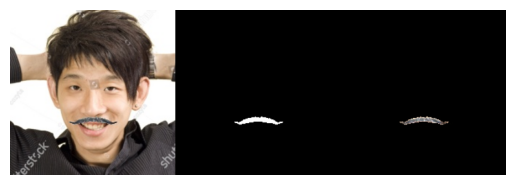

In [ ]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([array_to_img(img), array_to_img(msk), array_to_img(img*msk)], axis = 1))

## Definición U-Net
La siguiente función define la estructura de la U-Net mediante dos bloques principales: el encoder y el decoder; con la particularidad de añadir skip connections entre las capas "simétricas" de la red.



In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)

  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'adam', loss='binary_crossentropy', run_eagerly=True)

  return model

In [ ]:
model = unet()

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

Función que controla los pasos del entrenamiento y que guarda los checkpoints del modelo.

In [55]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='/content/drive/MyDrive/MG_Utils/chekpointsIsma/unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print(f"Epoch {epoch+1}: loss={logs.get('loss')}, val_loss={logs.get('val_loss')}, mean_iou={logs.get('mean_iou')}, val_mean_iou={logs.get('val_mean_iou')}")

        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'/content/drive/MyDrive/MG_Utils/data/train/image1/{path}')
        ancho,alto = raw.size
        raw = raw.crop((0, 0, ancho // 2, alto))
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        msk = np.array(model.predict(np.expand_dims(raw, 0)))

        #mask post-processing
        msk  = msk.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        #msk[msk >= 0.5] = 1
        #msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([array_to_img(raw), array_to_img(msk)], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Epoch 1: loss=0.003534021321684122, val_loss=0.0035006783436983824, mean_iou=None, val_mean_iou=None
i= 1 loss= 0.003534021321684122 val_loss= 0.0035006783436983824 mean_iou= None val_mean_iou= None
1/1 [==============================] - 0s 52ms/step


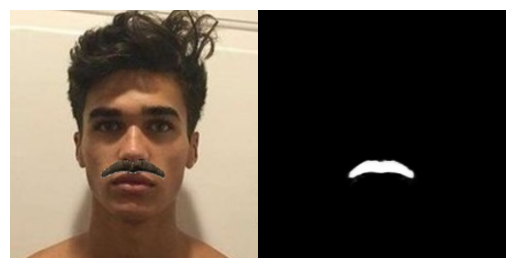

Epoch 2: loss=0.003360083093866706, val_loss=0.003336764872074127, mean_iou=None, val_mean_iou=None
i= 2 loss= 0.003360083093866706 val_loss= 0.003336764872074127 mean_iou= None val_mean_iou= None
1/1 [==============================] - 0s 81ms/step


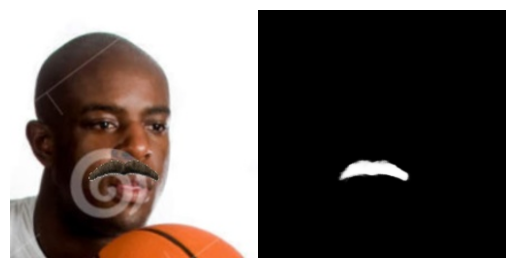

Epoch 3: loss=0.0035635088570415974, val_loss=0.003371243132278323, mean_iou=None, val_mean_iou=None
i= 3 loss= 0.0035635088570415974 val_loss= 0.003371243132278323 mean_iou= None val_mean_iou= None
1/1 [==============================] - 0s 50ms/step


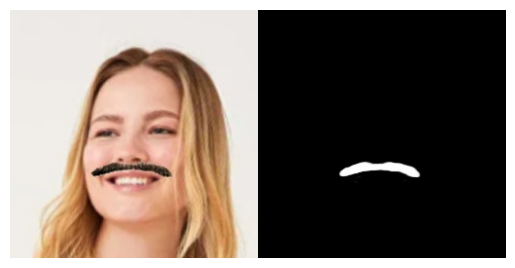

KeyboardInterrupt: ignored

In [56]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit(train_generator, epochs = 100, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
          callbacks = build_callbacks(), verbose = 0)

In [75]:
model.load_weights("/content/drive/MyDrive/MG_Utils/UNET/unet.h5")

## Procesador Ruido

Añade ruido al área donde está la máscara.

Recibe de entrada una imagen sin máscara y la imagen de la máscara binaria, y aplica ruido a la imagen sin máscara en la zona donde estaría la máscara. Se aplica ruido para potenciar el rendimiento del algoritmo



In [ ]:
import numpy as np
import cv2
def noise_processing(mask_image, generate_image):

    images = []
    noise = np.random.rand(256, 256, 3)*255.0
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    batch = mask_image.shape[0]

    for i in range(batch):
        image = mask_image[i, :, :, :]
        mask = generate_image[i, :, :, :]
        # mask = cv2.erode(mask, k)             #  mask  Morphology Preprocesamiento
        # mask = cv2.dilate(mask, k)
        mask = mask *255.
        image = image *255.
        # _, mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY)   #  mask 전처리

        # Masking된 RGB채널에 노이즈 생성
        image1 = np.where(mask[:,:,0] < 0.5, image[:, :, 0], noise[:,:,0])
        image2 = np.where(mask[:,:,1] < 0.5, image[:, :, 1], noise[:,:,1])
        image3 = np.where(mask[:,:,2] < 0.5, image[:, :, 2], noise[:,:,2])

        image1 = image1[:, :, np.newaxis]
        image2 = image2[:, :, np.newaxis]
        image3 = image3[:, :, np.newaxis]

        noise_image = np.concatenate([image1, image2], axis=-1)
        noise_image = np.concatenate([noise_image, image3], axis=-1)

        images.append(noise_image[np.newaxis, :, :, :])

    image_input = np.array(images).reshape((batch, 256, 256, 3))
    image_input = tf.convert_to_tensor(image_input, dtype=tf.float32)
    return image_input / 255.

In [ ]:
imagen = Image.open('/content/drive/MyDrive/MG_Utils/data/train/image1/with_mask_0011543.jpg')
ancho,alto = imagen.size
raw = imagen.crop((0, 0, ancho // 2, alto))

raw2 = imagen.crop(( ancho // 2, 0, ancho-2 , alto))

raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

raw2 = np.array(raw2.resize((256, 256)))/255.
raw2 = raw2[:,:,0:3]

help = raw2


aa = model.predict(np.expand_dims(raw, 0))
aa = aa.squeeze()
aa = np.stack((aa,)*3, axis=-1)
aa = np.expand_dims(aa, 0)

raw2= np.expand_dims(raw2, 0)
image = noise_processing(raw2, aa)

1/1 [==============================] - 0s 107ms/step


### Muestra del funcionamiento del noise processing

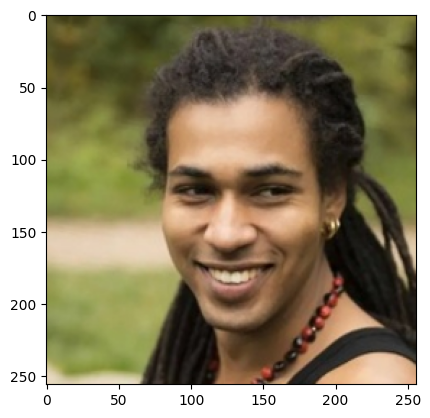

In [ ]:
raw = Image.open('/content/drive/MyDrive/MG_Utils/data/train/image1/with_mask_0011543.jpg')
ancho,alto = raw.size
#raw = raw.crop((0, 0, ancho // 2, alto))
raw2 = raw.crop(( ancho // 2, 0, ancho-1 , alto))
raw2 = np.array(raw2.resize((256, 256)))/255.
raw2 = raw2[:,:,0:3]


plt.imshow(array_to_img(raw2))

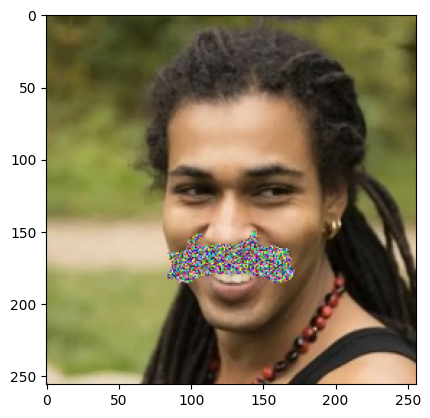

In [ ]:
plt.imshow(array_to_img(image[0]))

#print(aa[0])

# GAN

## Bloques downsample y upsample de la U-net del generador, y definición del Generador

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def face_generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, 3,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Discriminador

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

## Modelo

In [ ]:
face_generator = face_generator()
discriminator = Discriminator()

## Definición de pérdidas del modelo conjunto

In [ ]:
LAMBDA = 100
face_generator_BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def face_generator_loss(disc_generated_output, gen_output, target):
  gan_loss = face_generator_BCE(tf.ones_like(disc_generated_output), disc_generated_output)
  ssim_loss = tf.image.ssim(target, gen_output, max_val=1.0)
  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = ssim_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = face_generator_BCE(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = face_generator_BCE(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Función para mostrar las imágenes generadas

In [ ]:
def generate_images2(model, test_input, tar):
  prediction = model(test_input, training=False)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = face_generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, _, _= face_generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          face_generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          face_generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

## Entrenamiento modelo final

In [73]:
from IPython import display
def fit(train_ds, test_ds, epoch):

  dataSet = tf.data.Dataset.zip((train_ds, test_ds))
  for num in range(epoch):
    start = time.time()
    print("Epoch: ", num+1)
    for step, ((mask_input, real_input), target) in enumerate(dataSet):
      raw = array_to_img(mask_input[0])
      raw = np.array(raw.resize((256, 256)))/255.
      raw = raw[:,:,0:3]
      input_image = model.predict(np.expand_dims(raw, 0))

      input_image = input_image.squeeze()
      input_image = np.stack((input_image,)*3, axis=-1)
      input_image = np.expand_dims(input_image, 0)

      real_input = np.array(real_input)

      target = np.array(target)


      input_image = noise_processing(real_input, input_image)
      #real_input = real_input.squeeze()
      if (step) % 100 == 0:
        display.clear_output(wait=True)

        if step != 0:
          print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

        start = time.time()

        generate_images2(face_generator, input_image, real_input)
        print(f"Step: {step//100}")

      train_step(input_image, real_input, step)

      # Training step
      if (step+1) % 10 == 0:
        print('.', end='', flush=True)


      # Save (checkpoint) the model every 600 steps
      if (step + 1) % 200 == 0:
          face_generator.save("/content/drive/MyDrive/MG_Utils/checkpointsIsma/face_gen_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))
          discriminator.save("/content/drive/MyDrive/MG_Utils/checkpointsIsma/face_dis_epoch{epoch}_step{step}.h5".format(epoch=num+1, step=step+1))


## Carga de pesos del modelo ya entrenado

In [77]:
face_generator.load_weights("/content/drive/MyDrive/MG_Utils/checkpointsIsma/face_dis_epoch15_step1000.h5")
discriminator.load_weights ("/content/drive/MyDrive/MG_Utils/checkpointsIsma/face_gen_epoch15_step1000.h5")

Time taken for 100 steps: 36.27 sec



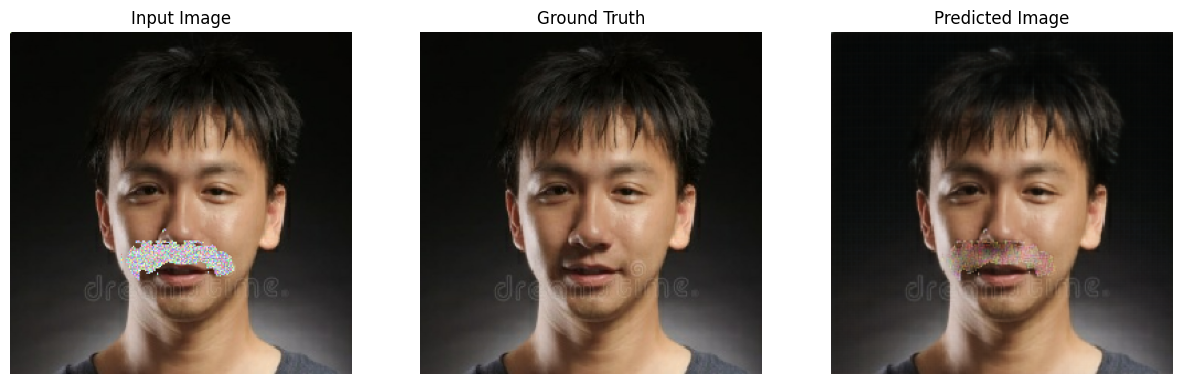

Step: 10
1/1 [==============================] - 0s 48ms/step
.

In [103]:
fit(mask_face_dataset, binary_dataset, epoch=15)

# Model Test

En estas celdas hacemos una pequeña prueba del modelo, quitándole (o al menos intentándolo) el bigote a Milo Ventimiglia.

1/1 [==============================] - 0s 52ms/step


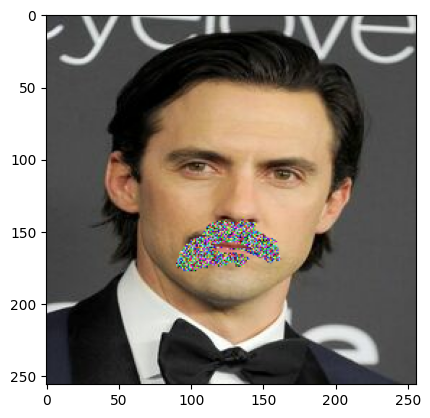

In [104]:
image = '/content/drive/MyDrive/MG_Utils/data/test/Bigotudo4.jpg'
image= binary_load(image)
image = array_to_img(image)

raw = np.array(image.resize((256, 256)))/255.
raw = raw[:,:,0:3]
mask = model.predict(np.expand_dims(raw, 0))
mask = mask.squeeze()
mask = np.stack((mask,)*3, axis=-1)
mask = np.expand_dims(mask, 0)

raw= np.expand_dims(raw, 0)

con_ruido = noise_processing(raw, mask)
sin_bigote = face_generator(con_ruido, training=False)
plt.imshow(array_to_img(con_ruido[0]))

(1, 256, 256, 3)


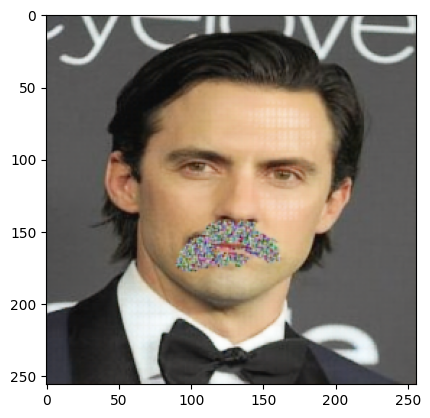

In [105]:
print(sin_bigote.shape)
plt.imshow(array_to_img(sin_bigote[0]))